# Import

In [102]:
from pandas import read_csv
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
import seaborn as sns
from pandas import concat

import numpy as np
import datetime

In [103]:
import warnings
warnings.filterwarnings('ignore')

# Load data

In [104]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d %H:%M:%S')

train = read_csv('data/transformed/2000_2021_Brazilian_North_Region_hourly_MWmed_hydroelectric_power_series.csv',
                 header=0, names=['index','value', 'date'], index_col='index', parse_dates=True, squeeze=True)
train['value'] = train['value'].astype(float)
train['date'] = train['date'].astype('datetime64')
train = train[train['value'] > 0.0]

train.head()

,value,date
index,,
2000-01-01 00:00:00,2422.5,2000-01-01 00:00:00
2000-01-01 01:00:00,2769.3,2000-01-01 01:00:00
2000-01-01 02:00:00,3124.7,2000-01-01 02:00:00
2000-01-01 03:00:00,3154.6,2000-01-01 03:00:00
2000-01-01 04:00:00,3121.8,2000-01-01 04:00:00


In [105]:
split_date = '1/1/2019 12:00:00 AM'
test  = train[split_date : ]
train = train[ : split_date]

test.head()

,value,date
index,,
2019-01-01 00:00:00,7297.073,2019-01-01 00:00:00
2019-01-01 01:00:00,6900.449,2019-01-01 01:00:00
2019-01-01 02:00:00,6869.606,2019-01-01 02:00:00
2019-01-01 03:00:00,6856.405,2019-01-01 03:00:00
2019-01-01 04:00:00,6853.338,2019-01-01 04:00:00


# Concatenate train and test series to plotting

In [106]:
train = train['value']
test = test['value']
series = concat([train, test], axis=0)
series

index
2000-01-01 00:00:00    2422.500
2000-01-01 01:00:00    2769.300
2000-01-01 02:00:00    3124.700
2000-01-01 03:00:00    3154.600
2000-01-01 04:00:00    3121.800
                         ...   
2021-01-30 20:00:00    7217.682
2021-01-30 21:00:00    7187.145
2021-01-30 22:00:00    6658.727
2021-01-30 23:00:00    6529.498
2021-01-31 00:00:00    6279.152
Name: value, Length: 184783, dtype: float64

# Prepare data

O que o modelo de persistencia faz?

O modelo de persistencia fala que o valor de n é igual ao de n + 1.

In [107]:
def persistence(last_ob, n_steps):
    return [last_ob for i in range(n_steps)]


test = test.values
series = series.values
train = [x for x in train]

# Number of multi-step
n_steps = 24

# Store multi-step forecasts
forecasts = list()

# Number of multi-step forecasts
n_forecasts = len(test) - n_steps + 1

# Walk-forward validation
for i in range(n_forecasts):
    # Make a multi-step forecast
    last_ob = train[-1]
    yhat = persistence(last_ob, n_steps)
    
    # Store the multi-step forecast
    forecasts.append(yhat)
    
    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)

print(train[-10:])
print(forecasts[-10:])

[8566.823, 8271.562, 8012.252, 8290.312, 8289.579, 8273.642, 7498.538, 6300.131, 5519.645, 5425.253]
[[9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427], [8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823], [8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562], [8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8

# Evaluate the forecasts

O resultado do modelo de persistencia da a baseline. Basicamente permite comparar outros modelos com o seu resultado para assim checar sua eficiencia.

Vantangens do modelo de persistencia:
- Simples
- Rapido
- Facil de replicar

In [108]:
# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps):
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]
        
        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        print(f"t+{(i+1)} RMSE: {sqrt(mean_squared_error(ytrue_ts, ypred_ts))}")


evaluate_forecasts(test, forecasts, n_steps)

t+1 RMSE: 409.6679707744369
t+2 RMSE: 702.4252573745656
t+3 RMSE: 930.8436093712165
t+4 RMSE: 1123.278275355191
t+5 RMSE: 1286.3788091984102
t+6 RMSE: 1424.4259975880425
t+7 RMSE: 1538.5519571245466
t+8 RMSE: 1628.6314821337453
t+9 RMSE: 1696.2535587357004
t+10 RMSE: 1744.4603870372187
t+11 RMSE: 1777.5107859972222
t+12 RMSE: 1796.7560491423558
t+13 RMSE: 1800.065064700899
t+14 RMSE: 1792.0138367423424
t+15 RMSE: 1772.0411287271495
t+16 RMSE: 1736.9171166598487
t+17 RMSE: 1685.2838250478333
t+18 RMSE: 1617.0319445060563
t+19 RMSE: 1535.8141285704728
t+20 RMSE: 1447.0591545233078
t+21 RMSE: 1356.3109858244673
t+22 RMSE: 1272.7963562423045
t+23 RMSE: 1206.1293188346324
t+24 RMSE: 1182.6876348271585


# Plot the forecasts

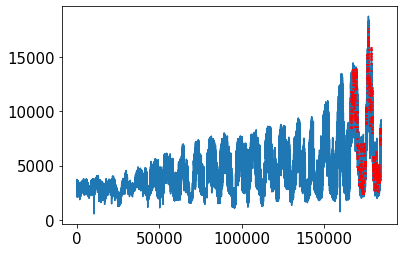

In [109]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
    # Plot the entire dataset in blue
    pyplot.plot(series)
    
    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1
        
        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1
        
        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        
        # Values of muti-step fotecasts
        yaxis = [series[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
        # sns.lineplot(data=xaxis, color='blue')
        # sns.lineplot(data=yaxis, color='red')

    # Show the final plot
    pyplot.show()


plot_forecasts(series, forecasts, test)